In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import os

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/ice_to_rock'

NHALO = 4
IC_FILE = 'MOM_IC.nc' # MOM6 output, coordinated with MOM_input & MOM_override
SHELF_IC_FILE = 'MOM_Shelf_IC.nc' # MOM6 output, coordinated with MOM_input & MOM_override
PROG_FILE = 'prog.nc' # MOM6 output, coordinated with diag_table
ICE_SHELF_FILE = '/INPUT/shelfX.nc'
TOPO_FILE = '/INPUT/topogX.nc'
THICKNESS_FILE = '/INPUT/thickness.nc'

In [ ]:
### New shelf
def make_shelf(filename):
    
    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:,:120] = 4000000 # ice
    #new_shelf["area"][:,60:120] = 4000000 # rock
    #new_shelf["area"][:,:60] = 0 # rock
    new_shelf["area"][:,120:] = 0
 
    bb4 = 333.2*np.ones(240)
    iip = 5
    for j in range(iip):
        bb4[120-j] = bb4[120-iip]*j/iip
    bb4[120:] = 0
    #bb4[:60] = 0 # rock
    new_shelf["thick"][:,:] = bb4

    new_shelf.close()    

In [ ]:
### New topography
def make_topography(filename):
    
    new_topog = nc.Dataset(filename, "w", format="NETCDF4")
    new_topog.createDimension("ny", 40)
    new_topog.createDimension("nx", 240)
    new_topog.createVariable("depth","f8",("ny","nx"))

    new_topog["depth"][:,:60] =  290  #(rock=0/ice=290)
    new_topog["depth"][:,60:] =  720

    new_topog.close()

In [2]:
### Turn an ice column into rock whenever the ice part and the rock part meets 
### Depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def rockify(shelf_filename, topo_filename):
    
    ice_shelf = xr.open_dataset(di + '/' + SHELF_IC_FILE)
    ic = xr.open_dataset(di + '/' + IC_FILE)
    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    print(np.nanmin(eta-bathyT))

    new_shelf = nc.Dataset(shelf_filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))
    new_shelf["thick"][:,:] = np.where(eta-bathyT<1e-3,[0],ice_shelf.h_shelf)
    new_shelf.close()

    new_topog = nc.Dataset(topo_filename, "w", format="NETCDF4")
    new_topog.createDimension("ny", 40)
    new_topog.createDimension("nx", 240)
    new_topog.createVariable("depth","f8",("ny","nx"))
    new_topog["depth"][:,:] = np.where(eta-bathyT<1e-3,[0],-bathyT)
    new_topog.close()

    ice_shelf.close()
    ic.close()

In [3]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
### depends on MOM6 output in IC_FILE
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [4]:
### 3D depiction of topography and ice shelf
### depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def display_config():
    
    ic = xr.open_dataset(di + "/"+ IC_FILE)
    ms = xr.open_dataset(di + "/" + SHELF_IC_FILE)
    #ms = xr.open_dataset(di + "/" + ICE_SHELF_FILE)
    #tp = xr.open_dataset(di + "/" + TOPO_FILE)

    LY, LX = ic.h.data[0].shape[1], ic.h.data[0].shape[2]
    YY= np.arange(0, LY, 1)
    XX = np.arange(0, LX, 1)
    XX, YY = np.meshgrid(XX, YY)

    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10,4), subplot_kw={"projection": "3d"})

    surf = axes[0].plot_surface(XX, YY, ms.h_shelf.data[0])
    #surf = axes[0].plot_surface(XX, YY, ms.thick.data)
    axes[0].set_title("Input ICE SHELF h")

    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    axes[1].plot_surface(XX, YY, eta)
    axes[1].plot_surface(XX, YY, bathyT)
    #topo2 = axes[1].plot_surface(XX, YY, -tp.depth.data)

    axes[1].set_title("Initial TOPOGRAPHY and ICE SHELF")

    ms.close()
    ic.close()

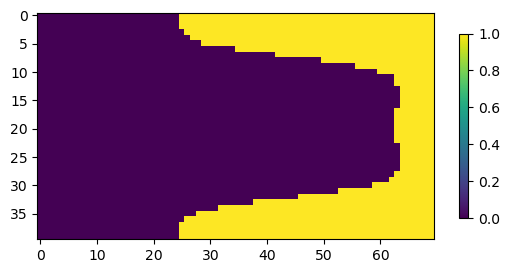

In [5]:
ice_shelf = xr.open_dataset(di + '/' + SHELF_IC_FILE)
ic = xr.open_dataset(di + '/' + IC_FILE)
eta = ic.eta[0].data[0]
bathyT = eta - np.sum(ic.h[0].data, axis=0)
plt.imshow(np.where(eta-bathyT<1e-3,[0],[1])[:,:70])
plt.colorbar(shrink=0.5)

In [6]:
!cat input.nml | tail

 
 &ocean_solo_nml
            months = 0
            date_init = 1,1,1,0,0,0
            days = 0
            hours = 0
            minutes = 0
            seconds = 300
            calendar = 'julian' /



In [7]:
!cat diag_table | head

"GOLD Experiment"
1 1 1 0 0 0
"prog",     300,"seconds",1,"days","Time"
"mom",     300,"seconds",1,"days","Time"
"forcing",     300,"seconds",1,"days","Time"
#"prog",     1,"hours",1,"days","Time"
#"mom",     1,"hours",1,"days","Time"
#"forcing",     1,"hours",1,"days","Time"
#"ave_prog", 5,"days",1,"days","Time",365,"days"
#"cont_%4yr_%3dy",     5,"days",1,"days","Time",365,"days"


In [8]:
! cat MOM_override | tail 


!!!!!!!!!!!!!!!!!  Thickness from  file   !!!!!!!!

!#override ADJUST_SALT = True

#override THICKNESS_CONFIG = "ISOMIP"     ! default = "uniform"
!#override THICKNESS_CONFIG = "thickness_file"     ! default = "uniform"
!#override THICKNESS_FILE = "thickness.nc"     ! default = "uniform"
!#override REMAP_AFTER_INITIALIZATION = False
!#override HACK_MODE = True


In [22]:
#make_shelf(di + ICE_SHELF_FILE)
#make_topography(di + TOPO_FILE)
#rockify(di + ICE_SHELF_FILE, di + TOPO_FILE)
make_thickness_file(di + THICKNESS_FILE)

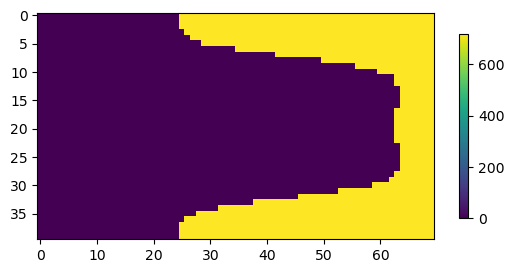

In [9]:
tp=xr.open_dataset(di + '/' + "/INPUT/topogX.nc")
plt.imshow(tp.depth.data[:,:70])
plt.colorbar(shrink=0.5)

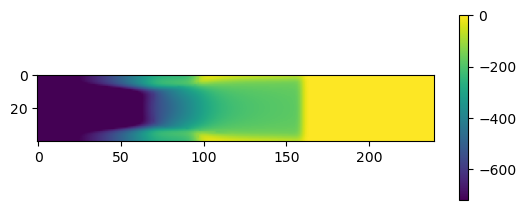

In [14]:
ic=xr.open_dataset(di + '/' + IC_FILE)
plt.imshow(ic.eta[0].data[0,:,:])
plt.colorbar(shrink=0.5)

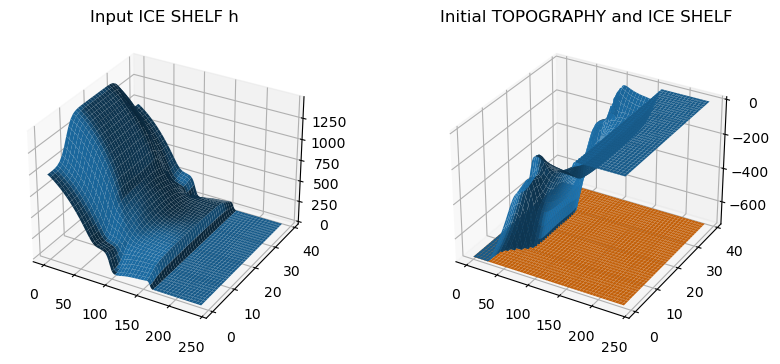

In [11]:
display_config()

### Plot output h,e,salt etc at chosen time

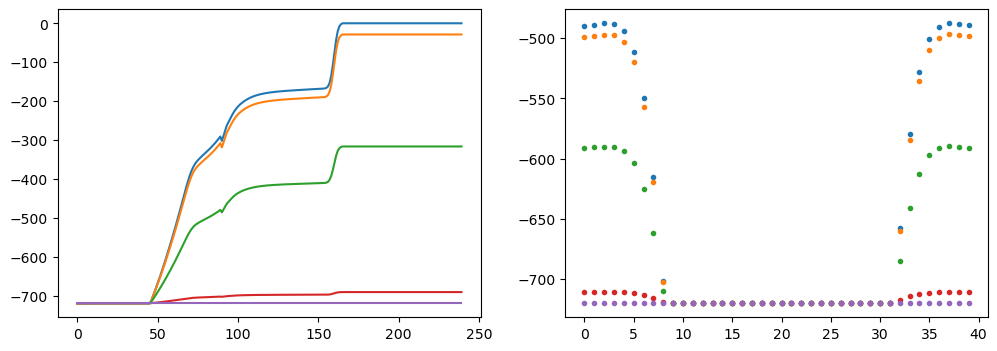

In [23]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
tt=0; zz= 11; yy=32; xx=51; ll = [0,1,zz,-2,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')

In [24]:
np.nanmin(prog.h[0].data)

1e-10

ttt = -1; zzz = 0
plt.plot(prog.salt.data[ttt][zzz][yy,:])

In [25]:
print(np.nanmax(prog.u.data[-1]), np.nanmin(prog.u.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

0.000236925932773065 -0.0054557721483320075


In [26]:
print(np.nanmax(prog.v.data[-1]), np.nanmin(prog.v.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

0.004728581285307744 -0.005315790797346


In [27]:
arr = prog.v.data[-1]
ind = np.unravel_index(np.nanargmax(arr),arr.shape)
print(arr[ind])
ind

0.004728581285307744


(21, 11, 62)

In [20]:
np.nanmin(prog.e.data[0])

-720.0

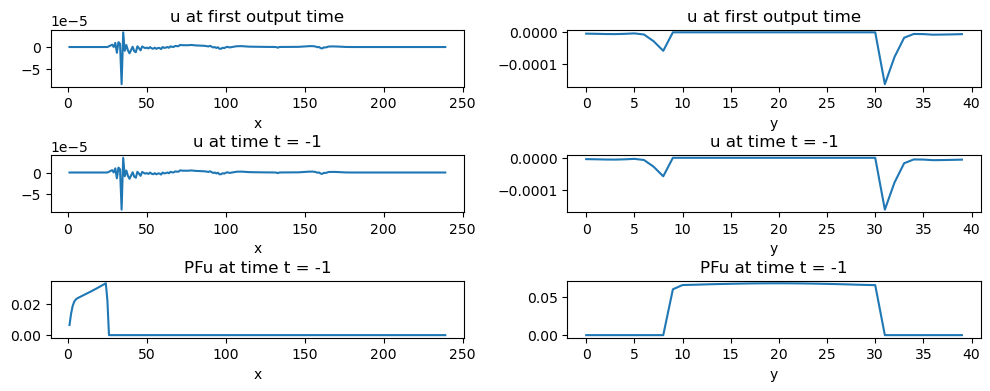

In [21]:
#aft = xr.open_dataset(di + '/after_ts_2_u.nc') # works only for 1 core, shows u after 1 time step
mo = xr.open_dataset(di + '/mom.nc')

fig,axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,4))

tt=-1; zz=7; yy=0; xx=56
#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0,0].plot(prog.u[0][zz].data[yy,:])
axes[0,0].set_xlabel("x")
axes[0,0].set_title("u at first output time") # depends on diag_table setting
#axes[0,1].plot(aft.u.data[zzz,NHALO:-NHALO,xx+NHALO],'o')
axes[0,1].plot(prog.u[0][zz].data[:,xx])
axes[0,1].set_xlabel("y")
axes[0,1].set_title("u at first output time") # depends on diag_table setting
axes[1,0].plot(prog.u[tt][zz].data[yy,:])
axes[1,0].set_xlabel("x")
axes[1,0].set_title("u at time t = {}".format(tt))
axes[1,1].plot(prog.u[tt][zz].data[:,xx])
axes[1,1].set_xlabel("y")
axes[1,1].set_title("u at time t = {}".format(tt))
axes[2,0].plot(mo.PFu[tt][zz].data[yy,:])
axes[2,0].set_xlabel("x")
axes[2,0].set_title("PFu at time t = {}".format(tt))
axes[2,1].plot(mo.PFu[tt][zz].data[:,xx])
axes[2,1].set_xlabel("y")
axes[2,1].set_title("PFu at time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 1.2)

mo.close()

In [ ]:
yy=10
tp=xr.open_dataset(di + '/' + "/INPUT/topogX.nc")
sh=xr.open_dataset(di + '/' + "/INPUT/shelfX.nc")
plt.plot(tp.depth.data[yy],'.')
plt.plot(sh.thick.data[yy])
tp.close()
sh.close()